# Prepare data in the format for modelling

In [1]:
import os
import numpy as np

import pandas as pd
from warnings import simplefilter
import sys
simplefilter(action='ignore', category=FutureWarning)
import geopy.distance

def add_sin_and_cos_features(df, column_to_transform):
    df['Sin_{}'.format(column_to_transform)] = np.sin(2 * np.pi * df[column_to_transform] / max(df[column_to_transform])) 
    df['Cos_{}'.format(column_to_transform)] = np.cos(2 * np.pi * df[column_to_transform] / max(df[column_to_transform]))
    return df

sys.path.append('../../3. Modelling')
from Functions import *

In [2]:
#buffer_sizes = [50, 100, 200, 400, 500, 600, 1000]
buffer_size_m = 50

### Prepare footfall data
<u> Including removing outliers:</u>  
The model should predict normal footfall. Therefore any days that have extremely high or low footfall should be taken out of the training data. We don't actually want the model to try to predict footfall on unusual days, because the things that make the day unusual (like errors in the camera counters, or the presence of special events) are not captured in the input data.

Outliers are detected using the Median Absolute Deviation method.

In [3]:
# Read in data
sensors = pd.read_csv('../../Cleaned_data/SensorData/allsensors.csv')
# Create month as number not string
sensors['datetime'] =pd.to_datetime(sensors['datetime'], format = '%Y-%m-%d %H:%M:%S')#dayfirst = False)
# Keep only data from 2011 onwards
sensors= sensors[sensors['year']>2010]
# # Create a categrorial variable defining the time of day
sensors['time_of_day'] = sensors.apply (lambda row: label_hours(row), axis=1)
sensors

/var/folders/bx/3j5z8qc50wl1tcff6xvbf2zh0000gs/T/ipykernel_9739/4006736533.py:2: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  sensors = pd.read_csv('../../Cleaned_data/SensorData/allsensors.csv')


,sensor_id,Name,sensor_name,installation_date,status,note,Latitude,Longitude,location,Note,...,Status,datetime,year,month,mdate,day,time,hourly_counts,new_sensor,time_of_day
0,16,Australia on Collins,Col270_T,30/03/2009,R,Device moved to location ID 53 (22/09/2015),-37.815734,144.965210,"(-37.81573422, 144.96521044)",NaN,...,NaN,2011-01-01 00:00:00,2011,1,1,Saturday,0,744,False,nighttime
1,5,Princes Bridge,PriNW_T,26/03/2009,A,NaN,-37.818742,144.967877,"(-37.81874249, 144.96787656)",NaN,...,NaN,2011-01-01 00:00:00,2011,1,1,Saturday,0,5021,False,nighttime
2,10,Victoria Point,BouHbr_T,23/04/2009,A,NaN,-37.818765,144.947105,"(-37.81876473, 144.94710545)",NaN,...,NaN,2011-01-01 00:00:00,2011,1,1,Saturday,0,518,False,nighttime
3,15,State Library,QV_T,25/03/2009,R,NaN,-37.810644,144.964471,"(-37.81064378, 144.96447132)",NaN,...,NaN,2011-01-01 00:00:00,2011,1,1,Saturday,0,1581,False,nighttime
4,3,Melbourne Central,Swa295_T,25/03/2009,A,NaN,-37.811015,144.964295,"(-37.81101523, 144.96429485)",NaN,...,NaN,2011-01-01 00:00:00,2011,1,1,Saturday,0,2547,False,nighttime
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5480637,41,Flinders La-Swanston St (West),Swa31,29/06/2017,A,NaN,-37.816686,144.966897,"(-37.81668633, 144.96689733)",NaN,...,NaN,2024-09-17 03:00:00,2024,9,17,Tuesday,3,20,False,nighttime
5480638,4,Town Hall (West),Swa123_T,23/03/2009,A,NaN,-37.814880,144.966088,"(-37.81487988, 144.9660878)",NaN,...,NaN,2024-09-17 03:00:00,2024,9,17,Tuesday,3,14,False,nighttime
5480639,63,231 Bourke St,Bou231_T,07/01/2020,A,NaN,-37.813331,144.966756,"(-37.81333081, 144.96675572)",NaN,...,NaN,2024-09-17 03:00:00,2024,9,17,Tuesday,3,5,False,nighttime
5480640,42,Grattan St-Swanston St (West),UM1_T,15/04/2015,A,NaN,-37.800086,144.963864,"(-37.80008565, 144.96386412)",NaN,...,NaN,2024-09-17 03:00:00,2024,9,17,Tuesday,3,9,False,nighttime


### Remove outliers (sensor by sensor)

In [4]:
pcts = []
all_sensors = pd.DataFrame({})
for sensor_id in np.unique(sensors['sensor_id']):
    #print(sensor_id)
    this_sensor = sensors[sensors['sensor_id']==sensor_id]
    this_sensor, outliers, pct = remove_outliers(this_sensor)
    pcts.append(pct)
    all_sensors = pd.concat([all_sensors, this_sensor])

In [5]:
sensors= all_sensors

In [6]:
# Drop unneeded columns
sensors=sensors.drop(['Latitude', 'Longitude', 'location', 'mdate'], axis=1)
# Check the data
sensors.head()
len(sensors)

5436604

### Inspect outliers which have been removed

In [7]:
# # Look at outliers from particular day (which have reason to believe might have incldued outliers)
# t = [pd.to_datetime('2020-03-07 13:00:00')]
# this_day = outliers[outliers['datetime'].isin(t)]#[2255323]['datetime']
# # Look at biggest outliers
# test = outliers.nlargest(5, 'hourly_counts')
# # outliers[outliers['sensor_id']==57]
# # fig,ax=plt.subplots(figsize=(4,10))
# # outliers['sensor_id'].value_counts().sort_values().plot(kind = 'barh',ax=ax)
# test

### Inspecting sensor which has a lot of the outliers removed

In [8]:
# sensor_57 = sensors[sensors['sensor_id']==57]
# # Filter by a single date
# sensor_57_oneday = sensor_57[sensor_57['datetime'].dt.strftime('%Y-%m-%d') == "2019-11-15"]
# sensor_57_oneday.index=sensor_57_oneday['time']
# fig, ax = plt.subplots(figsize = (5,4), sharex = True)
# fig = sensor_57_oneday['hourly_counts'].plot(ax=ax, color='darkred', linewidth=2, legend =True)

## add date variables

In [9]:
sensors['day_of_month_num'] = sensors['datetime'].dt.day
sensors['weekday_num'] = sensors['datetime'].dt.weekday +1
sensors['month_num'] = sensors['datetime'].dt.month

### Join public holiday and weather data to sensor data (WHY DO NUMBER OF ROWS INCREASE SLIGHTLY?)

(_Code below added by NM because code above wasn't able to parse the dates correctly - probably a change in library versions_)

In [10]:
# Load and convert datetime columns explicitly
weather_data = pd.read_csv('../../Cleaned_data/WeatherData/weather_data_allyears.csv', parse_dates=['datetime'])
daily_rainfall = pd.read_csv('../../Cleaned_data/WeatherData/DailyRainfallData.csv', parse_dates=['datetime'])
public_holidays = pd.read_csv('../../Cleaned_data/HolidaysData/publicholidays.csv', parse_dates=['datetime'])
school_holidays = pd.read_csv('../../Cleaned_data/HolidaysData/schoolholidays.csv', parse_dates=['datetime'])

# Ensure datetime columns are in the correct format
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'], dayfirst=True)
daily_rainfall['datetime'] = pd.to_datetime(daily_rainfall['datetime'], dayfirst=True)
public_holidays['datetime'] = pd.to_datetime(public_holidays['datetime'], dayfirst=True)
school_holidays['datetime'] = pd.to_datetime(school_holidays['datetime'], dayfirst=True)

# Merge the dataframes
sensors_with_features = sensors.merge(weather_data, on='datetime', how='left')
sensors_with_features = sensors_with_features.merge(daily_rainfall, on='datetime', how='left')
sensors_with_features = sensors_with_features.merge(public_holidays, on='datetime', how='left')
sensors_with_features = sensors_with_features.merge(school_holidays, on='datetime', how='left')

# Also bring in the features near the sensors (no time column co can be merged directly)
sensors_with_features = sensors_with_features.merge(
    pd.read_csv('../../Cleaned_data/SpatialFeatures/sensors_betweenness.csv'), how='left', on='sensor_id')
sensors_with_features = sensors_with_features.merge(
    pd.read_csv('../../Cleaned_data/FeaturesNearSensors/num_features_near_sensors_{}.csv'.format(buffer_size_m), index_col=0), how='left', on='sensor_id')
sensors_with_features = sensors_with_features.merge(
    pd.read_csv('../../Cleaned_data/FeaturesNearSensors/feature_subtypes_near_sensors_{}.csv'.format(buffer_size_m), index_col=0), how='left', on='sensor_id')

In [11]:
print("Length is now: " , len(sensors_with_features))

Length is now:  5436621


### Add average number of floors of building in vicinity, for correct year 

In [12]:
sensors_with_features['avg_n_floors'] = sensors_with_features.apply (lambda row: select_n_floors(row), axis=1)
sensors_with_features = sensors_with_features[sensors_with_features.columns.drop(list(sensors_with_features.filter(regex='avg_n_floors_')))]

### Add buildings (correctly for the year the data relates to)

In [13]:
# FOR SENSORS WITH FEATURES
sensors_with_features['buildings'] = sensors_with_features.apply (lambda row: select_buildings(row), axis=1).copy()
sensors_with_features= sensors_with_features.drop(['buildings_2010', 'buildings_2011','buildings_2012', 'buildings_2013',
                                                  'buildings_2014','buildings_2015','buildings_2016','buildings_2017',
                                                  'buildings_2018', 'buildings_2019', 'buildings_2020'], axis =1)
# FOR SENSORS WITH SUBFEATURES
# Create a dataframe containing just the building subttypes for the year that this row refers to
temp = pd.DataFrame(None)
# For each year, get the data for just that year
for year in range(2011,2022+1):   
    # Get just footfall data for this year
    this_year = sensors_with_features[sensors_with_features['year'] == year]
    # If year is over 2020 then set the year to 2020 for the purposes of selecting the building data 
    if year > 2020:
        year = 2020
    # Get just the building columns for this year
    buildings_this_yr = this_year.filter(like='{}'.format(year))
    # Drop all the building subtype columns from the row (and the bikes) 
    this_year = this_year[this_year.columns.drop(list(this_year.filter(regex='bikes|buildings_')))]
     # Join the row without any buildings, back to this row 
    this_year = pd.concat([this_year, buildings_this_yr], axis=1)
    # Rename -- ??
    this_year.columns = this_year.columns.str.replace(r'_{}'.format(year), '')
    # Join to dataframe which will store data for all years eventually
    temp = pd.concat([temp, this_year])
sensors_with_features = temp.copy()

### Add dummy variables for calendar variables 
(Not doing this anymore as creating cos and sin variables)

In [14]:
# sensors_with_features=convert_df_variables_to_dummy(sensors_with_features, ['day', 'month', 'year', 'time'])
# sensors_with_features=convert_df_variables_to_dummy(sensors_with_features, ['time_of_day'])
# sensors_with_features = sensors_with_features.drop(['datetime'],axis=1)

### Date based variables: Option 2 - Create Dummy Variables
for date_col in ['day', 'month',]:
    date_col_dummy =  pd.get_dummies(sensors_with_features[date_col], drop_first = True)
    if date_col =='month':
        date_col_dummy.columns= prepend(date_col_dummy.columns.values, 'month_')
    # if date_col =='year':
        # date_col_dummy.columns= prepend(date_col_dummy.columns.values, 'year_')
    sensors_with_features = pd.concat([sensors_with_features, date_col_dummy],axis=1)
    del sensors_with_features[date_col]

### Create sin/cos variables to represent cyclical features

In [15]:
# Time refers to the hour of the day 0-23 (makes sense that this is cyclical - relationship between 23 and 0)
sensors_with_features = add_sin_and_cos_features(sensors_with_features, 'time')
# Month number from 1-12 (makes sense that this is cyclical - relationship between 12 and 1)
sensors_with_features = add_sin_and_cos_features(sensors_with_features, 'month_num')
# Weekday number from 1-7 (maybe doesnt make sense that this is cyclical - doesn't really follow a logical pattern?
sensors_with_features = add_sin_and_cos_features(sensors_with_features, 'weekday_num')

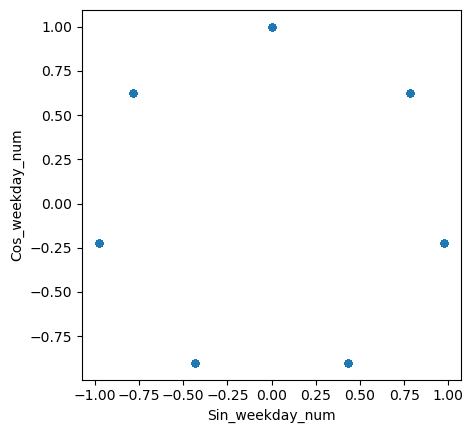

In [16]:
ax = sensors_with_features.plot.scatter('Sin_weekday_num', 'Cos_weekday_num').set_aspect('equal')

### Replace NaNs with 0s

In [17]:
sensors_with_features= sensors_with_features.fillna(0)

## Create aggregated data

In [18]:
# ### Filter to include just sensors which we know have quite complete data 
# data = sensors_with_features[sensors_with_features['sensor_id'].isin([2,6,9,10,14,18])]
# data.reset_index(inplace=True, drop = True)

# # Get just this hourly counts
# hourly_counts = data[['datetime', "hourly_counts"]]
# # Get the sum of all values for one hour
# summed_hourly_counts = hourly_counts.groupby("datetime").sum()
# # reset index (for joining)
# summed_hourly_counts.reset_index(inplace = True, drop = True)

# # Get just the features
# features = data[['datetime','Temp', 'Humidity', 'Pressure', 'Rain', 'WindSpeed',
#        'public_holiday','school_holiday','Sin_time', 'Cos_time', 'Sin_month_num', 'Cos_month_num', 'Sin_weekday_num', 'Cos_weekday_num']]
# # Keep only one version of each row (should all be the same)
# features = features.drop_duplicates(keep='last')
# # reset index (for joining)
# features.reset_index(inplace = True, drop = True)

# # Join features to aggregated count values
# aggregated = pd.concat([summed_hourly_counts, features], axis=1, join='inner')

In [19]:
# for column in sensors_with_features.columns:
#     print(column, np.nanmax(sensors_with_features[column]))

### Remove time variables no longer required

In [20]:
# sensors_with_features = sensors_with_features.drop([ 'Sin_month_num', 'Cos_month_num', 'Sin_weekday_num',
#        'Cos_weekday_num',],axis=1)

### Add distance from centre as a variable

In [21]:
### Read in Melbourne sensor location spatial data
melbourne_sensors = pd.read_csv("../../Cleaned_data/SensorData/sensor_locations.csv")
melbourne_sensors.rename(columns={'sensor_description': 'Name'}, inplace = True)
melbourne_sensors = melbourne_sensors.drop_duplicates('sensor_id', keep='first')

# Coordinates of 'centre' of CBD (done on google maps)
coords_1 = (-37.812187461761596, 144.962265054567)
distances =[]
for row_number in range(0,len(melbourne_sensors)):
    coords_2 = (melbourne_sensors['Latitude'][row_number], melbourne_sensors['Longitude'][row_number])
    distances.append(geopy.distance.geodesic(coords_1, coords_2).km)
    
melbourne_sensors['distance_from_centre']=distances
melbourne_sensors=melbourne_sensors[['sensor_id','distance_from_centre']]

In [22]:
sensors_with_features= pd.merge(sensors_with_features, melbourne_sensors, on=['sensor_id'], how='left')

### Save as csv

In [23]:
dir="../../Cleaned_data/FormattedDataForModelling/"
os.makedirs(dir, exist_ok=True)
sensors_with_features.to_csv(dir+"formatted_data_for_modelling_allsensors_{}_outlierremovaleachsensor.csv".format(buffer_size_m),
                            index = False)